# Explore Classic Architectures
## Goal
- Compare classic architectures on x-ray images to determine how well they perform
- Models Include:
    - LeNet5
    - AlexNet
    - SimpleResNet
    - CustomResNet50

## Conclusion
- LeNet5 provided the best results
- I will use this as a basis for developing a model

In [1]:
# Standard Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

# Modeling Imports
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, Add, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score
from sklearn.utils import class_weight

# Lime Imports
%load_ext autoreload
%autoreload 2
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

import sys
sys.path.append('../../src')
import functions as fx

In [2]:
train_path = '../../chest_xray/train'
test_path = '../../chest_xray/new_test'
val_path = '../../chest_xray/new_val'
# Include data augmentation with training data, and 
train_generator = ImageDataGenerator(rescale = 1./255.,
                                    rotation_range = 30, zoom_range = [0.9, 1.0],
                                    width_shift_range = 0.1, height_shift_range = 0.1,
                                    horizontal_flip = True) \
    .flow_from_directory(train_path, target_size = (256, 256), 
                         batch_size = 64, class_mode = 'binary')
test_generator = ImageDataGenerator(rescale = 1./255.) \
    .flow_from_directory(test_path, target_size = (256, 256), 
                         batch_size = 64, class_mode = 'binary')
val_generator = ImageDataGenerator(rescale = 1./255.) \
    .flow_from_directory(val_path, target_size = (256, 256), 
                         batch_size = 64, class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 524 images belonging to 2 classes.
Found 116 images belonging to 2 classes.


In [5]:
# Calculate weights to balance normal and pneumonia data in training set
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced', classes = np.unique(train_generator.classes), 
    y = train_generator.classes)
train_class_weights = dict(enumerate(class_weights))

In [28]:
# Stop training if val_loss does not decrease at least 0.01 in 5 epochs
early_stop_loss = EarlyStopping(monitor = 'val_loss', 
                                min_delta = 0.01, patience = 5, 
                                mode = 'min', restore_best_weights = True)
# Some of the models predicted all images were pneumonia
# and consistently resulted in val_accuracy=0.6034 and val_recall=1
# To break this loop, stop training if val_accuracy does not increase at least 0.01 in 5 epochs
early_stop_acc = EarlyStopping(monitor = 'val_accuracy', 
                               min_delta = 0.01, patience = 5, 
                               mode = 'max', restore_best_weights = True)

## Models
### LeNet5

In [29]:
def LeNet5(image):
    layers = [
        Input(image.shape),
        Conv2D(6, (5, 5), activation = 'relu'),
        AveragePooling2D((2, 2)),
        Conv2D(16, (5, 5), activation='relu'),
        AveragePooling2D((2, 2)),
        Flatten(),
        Dense(120, activation='relu'),
        Dense(82, activation = 'relu'),
        Dense(1, activation = 'sigmoid')
    ]
    model = Sequential(layers)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Recall'])
    return model

In [30]:
model_LeNet5 = LeNet5(train_generator[0][0][0])
model_LeNet5.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 252, 252, 6)       456       
_________________________________________________________________
average_pooling2d_2 (Average (None, 126, 126, 6)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 122, 122, 16)      2416      
_________________________________________________________________
average_pooling2d_3 (Average (None, 61, 61, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 59536)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 120)               7144440   
_________________________________________________________________
dense_8 (Dense)              (None, 82)               

In [31]:
result_LeNet5 = model_LeNet5.fit(train_generator, epochs = 20, validation_data=val_generator, 
                                 class_weight = train_class_weights, 
                                 callbacks = [early_stop_loss, early_stop_acc])

Epoch 1/20
82/82 [==============================] - 108s 1s/step - loss: 0.7513 - accuracy: 0.6273 - recall: 0.6560 - val_loss: 0.6527 - val_accuracy: 0.6466 - val_recall: 0.8429
Epoch 2/20
82/82 [==============================] - 104s 1s/step - loss: 0.4506 - accuracy: 0.7885 - recall: 0.7672 - val_loss: 0.7198 - val_accuracy: 0.6983 - val_recall: 0.5429
Epoch 3/20
82/82 [==============================] - 104s 1s/step - loss: 0.3102 - accuracy: 0.8641 - recall: 0.8508 - val_loss: 0.5249 - val_accuracy: 0.7672 - val_recall: 0.8714
Epoch 4/20
82/82 [==============================] - 104s 1s/step - loss: 0.2866 - accuracy: 0.8827 - recall: 0.8733 - val_loss: 0.5805 - val_accuracy: 0.7672 - val_recall: 0.8857
Epoch 5/20
82/82 [==============================] - 104s 1s/step - loss: 0.2649 - accuracy: 0.8882 - recall: 0.8782 - val_loss: 0.5114 - val_accuracy: 0.8103 - val_recall: 0.9000
Epoch 6/20
82/82 [==============================] - 104s 1s/step - loss: 0.2774 - accuracy: 0.8854 - reca

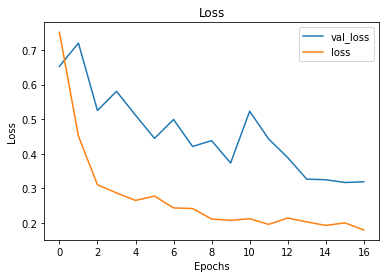

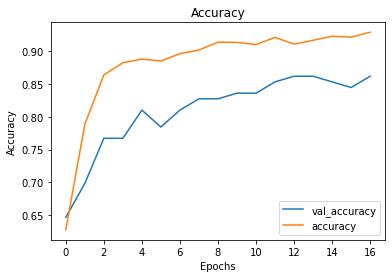

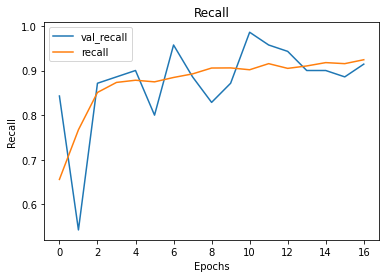

In [32]:
fx.visualize_training_results(result_LeNet5)

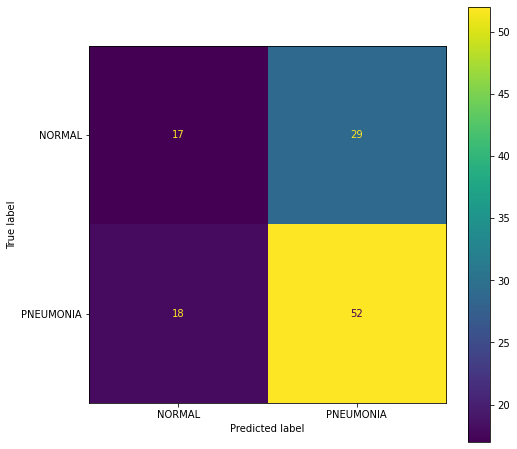

In [33]:
fx.create_confusion_matrix(model_LeNet5, val_generator)

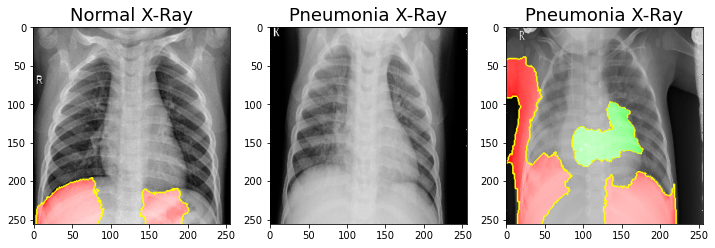

In [50]:
fx.display_lime(model_LeNet5, val_generator)

### AlexNet

In [34]:
def AlexNet(image):
    layers = [
        Input(image.shape),
        Conv2D(96, (11, 11), activation = 'relu'),
        BatchNormalization(),
        MaxPooling2D((3, 3)),
        Conv2D(256, (5, 5), padding = 'same', activation = 'relu'),
        BatchNormalization(),
        MaxPooling2D((3, 3)),
        Conv2D(384, (3, 3), padding = 'same', activation = 'relu'),
        BatchNormalization(),
        Conv2D(384, (3, 3), activation = 'relu'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation = 'relu'),
        BatchNormalization(),
        MaxPooling2D((3, 3)),
        Flatten(),
        Dense(9216, activation = 'relu'),
        Dropout(0.5),
        Dense(4096, activation = 'relu'),
        Dropout(0.5),
        Dense(4096, activation = 'relu'),
        Dropout(0.5),
        Dense(1, activation = 'sigmoid')
    ]
    model = Sequential(layers)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Recall'])
    return model

In [35]:
model_AlexNet = AlexNet(train_generator[0][0][0])
model_AlexNet.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 246, 246, 96)      34944     
_________________________________________________________________
batch_normalization_5 (Batch (None, 246, 246, 96)      384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 82, 82, 96)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 82, 82, 256)       614656    
_________________________________________________________________
batch_normalization_6 (Batch (None, 82, 82, 256)       1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 256)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 27, 27, 384)      

In [36]:
result_AlexNet = model_AlexNet.fit(train_generator, epochs = 20, validation_data=val_generator,
                                   class_weight = train_class_weights, 
                                   callbacks = [early_stop_loss, early_stop_acc])

Epoch 1/20
82/82 [==============================] - 848s 10s/step - loss: 6.5864 - accuracy: 0.6927 - recall: 0.6983 - val_loss: 7.8936 - val_accuracy: 0.6207 - val_recall: 1.0000
Epoch 2/20
82/82 [==============================] - 896s 11s/step - loss: 0.4643 - accuracy: 0.8012 - recall: 0.7938 - val_loss: 0.9011 - val_accuracy: 0.7155 - val_recall: 0.9571
Epoch 3/20
82/82 [==============================] - 915s 11s/step - loss: 0.3623 - accuracy: 0.8566 - recall: 0.8516 - val_loss: 5.8127 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 4/20
82/82 [==============================] - 1330s 16s/step - loss: 0.3644 - accuracy: 0.8554 - recall: 0.8472 - val_loss: 6.4224 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 5/20
82/82 [==============================] - 2711s 33s/step - loss: 0.3239 - accuracy: 0.8706 - recall: 0.8601 - val_loss: 0.8274 - val_accuracy: 0.6552 - val_recall: 0.6143
Epoch 6/20
82/82 [==============================] - 1933s 24s/step - loss: 0.3299 - accuracy: 0.88

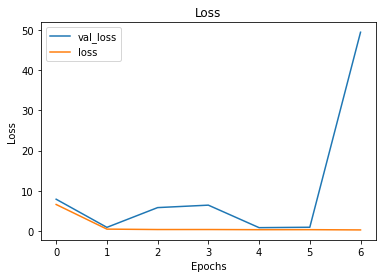

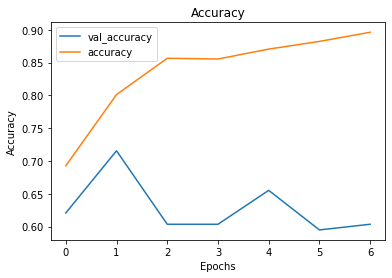

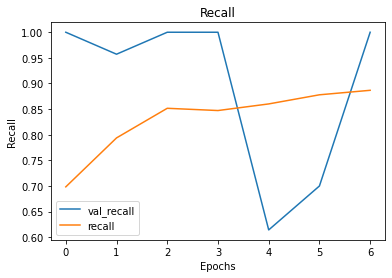

In [37]:
fx.visualize_training_results(result_AlexNet)

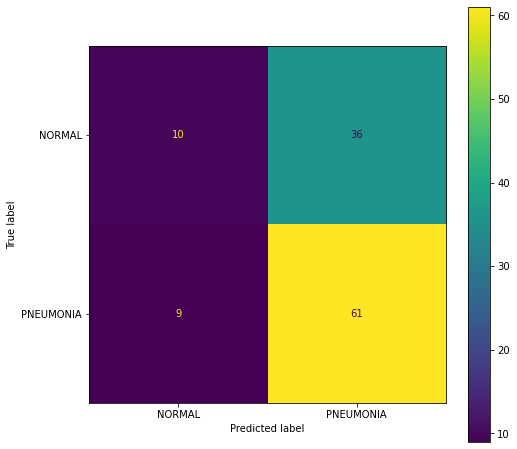

In [38]:
fx.create_confusion_matrix(model_AlexNet, val_generator)

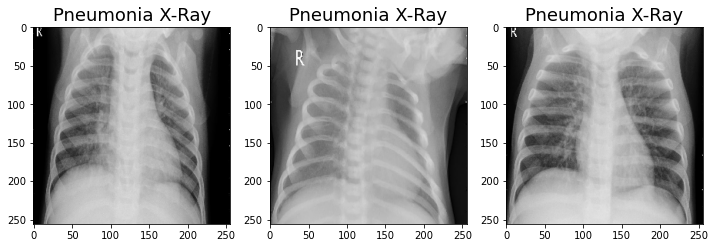

In [51]:
fx.display_lime(model_AlexNet, val_generator)

### SimpleResNet

In [39]:
def SimpleResNet(image):
    
    input_layer = Input(image.shape)
    
    X = Conv2D(64, (3, 3), activation = 'relu')(input_layer)
    X = BatchNormalization()(X)
    
    X_shortcut = X
    
    X = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(X)
    X = BatchNormalization()(X)
    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    X = Flatten()(X)
    X = Dense(1, activation = 'sigmoid')(X)

    model = Model(inputs = input_layer, outputs = X, name = 'ResNet')
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Recall'])
    return model

In [40]:
model_SimpleResNet = SimpleResNet(train_generator[0][0][0])
model_SimpleResNet.summary()

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 254, 254, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 254, 254, 64) 256         conv2d_14[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 254, 254, 64) 36928       batch_normalization_10[0][0]     
_____________________________________________________________________________________________

In [41]:
result_SimpleResNet = model_SimpleResNet.fit(train_generator, epochs = 20, validation_data=val_generator, 
                                             class_weight = train_class_weights, 
                                             callbacks = [early_stop_loss, early_stop_acc])

Epoch 1/20
82/82 [==============================] - 669s 8s/step - loss: 70.3634 - accuracy: 0.7615 - recall: 0.7566 - val_loss: 7.6201 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 2/20
82/82 [==============================] - 661s 8s/step - loss: 18.0142 - accuracy: 0.8397 - recall: 0.8387 - val_loss: 5.2443 - val_accuracy: 0.5259 - val_recall: 0.8429
Epoch 3/20
82/82 [==============================] - 653s 8s/step - loss: 17.1144 - accuracy: 0.8677 - recall: 0.8681 - val_loss: 30.3955 - val_accuracy: 0.5948 - val_recall: 0.9714
Epoch 4/20
82/82 [==============================] - 644s 8s/step - loss: 22.3749 - accuracy: 0.8654 - recall: 0.8666 - val_loss: 5.6825 - val_accuracy: 0.7241 - val_recall: 0.8286
Epoch 5/20
82/82 [==============================] - 576s 7s/step - loss: 21.9803 - accuracy: 0.8765 - recall: 0.8761 - val_loss: 26.7711 - val_accuracy: 0.5948 - val_recall: 0.8286
Epoch 6/20
82/82 [==============================] - 521s 6s/step - loss: 17.0956 - accuracy: 0.884

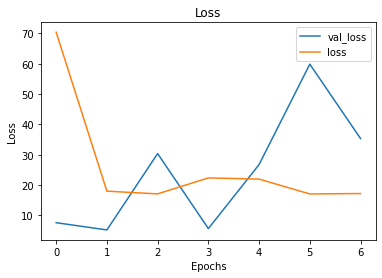

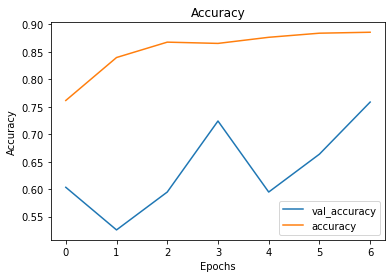

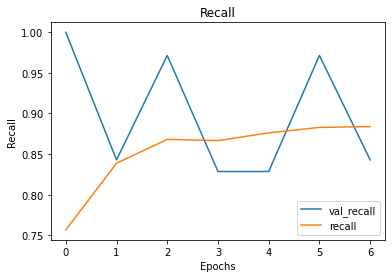

In [42]:
fx.visualize_training_results(result_SimpleResNet)

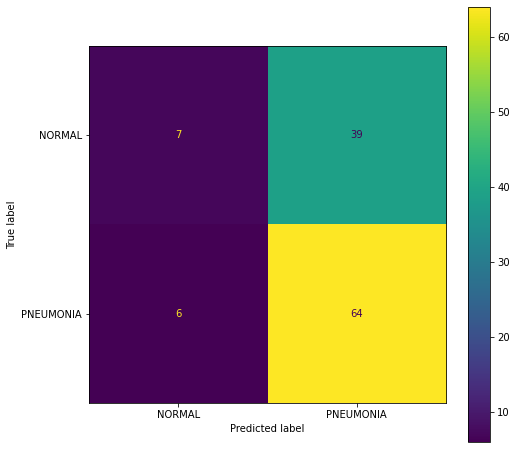

In [43]:
fx.create_confusion_matrix(model_SimpleResNet, val_generator)

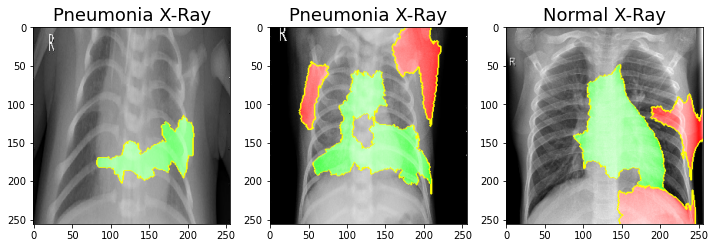

In [52]:
fx.display_lime(model_SimpleResNet, val_generator)

### CustomResNet50

In [44]:
def CustomResNet50(image):
    base_model = ResNet50(include_top = False, weights = None, input_shape = image.shape)
    
    X = base_model.output
    X = GlobalAveragePooling2D()(X)
    X = Dropout(0.5)(X)
    X = Dense(1, activation = 'sigmoid')(X)
    
    model = Model(inputs = base_model.input, outputs = X)
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Recall'])
    return model

In [45]:
model_CustomResNet50 = CustomResNet50(train_generator[0][0][0])
model_CustomResNet50.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [46]:
result_CustomResNet50 = model_CustomResNet50.fit(train_generator, epochs = 20, validation_data=val_generator, 
                                                 class_weight = train_class_weights, 
                                                 callbacks = [early_stop_loss, early_stop_acc])

Epoch 1/20
82/82 [==============================] - 946s 12s/step - loss: 0.4137 - accuracy: 0.8547 - recall: 0.8483 - val_loss: 3.6081 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 2/20
82/82 [==============================] - 938s 11s/step - loss: 0.2334 - accuracy: 0.9087 - recall: 0.9009 - val_loss: 8.1584 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 3/20
82/82 [==============================] - 953s 12s/step - loss: 0.1993 - accuracy: 0.9143 - recall: 0.9097 - val_loss: 5.0885 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 4/20
82/82 [==============================] - 944s 12s/step - loss: 0.2303 - accuracy: 0.9128 - recall: 0.9048 - val_loss: 1.8608 - val_accuracy: 0.6724 - val_recall: 0.9857
Epoch 5/20
82/82 [==============================] - 940s 11s/step - loss: 0.1813 - accuracy: 0.9250 - recall: 0.9177 - val_loss: 0.9521 - val_accuracy: 0.6897 - val_recall: 0.7286
Epoch 6/20
82/82 [==============================] - 951s 12s/step - loss: 0.1632 - accuracy: 0.9379 

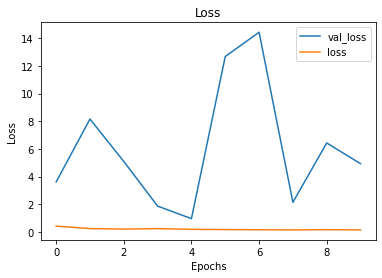

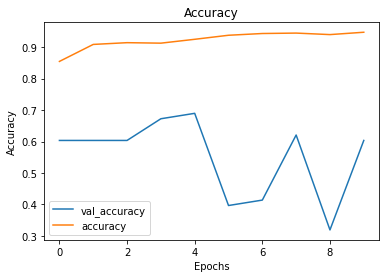

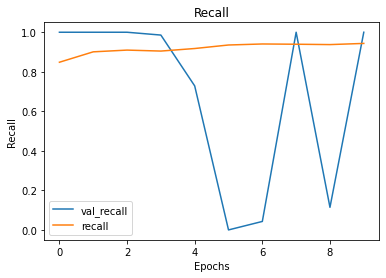

In [47]:
fx.visualize_training_results(result_CustomResNet50)

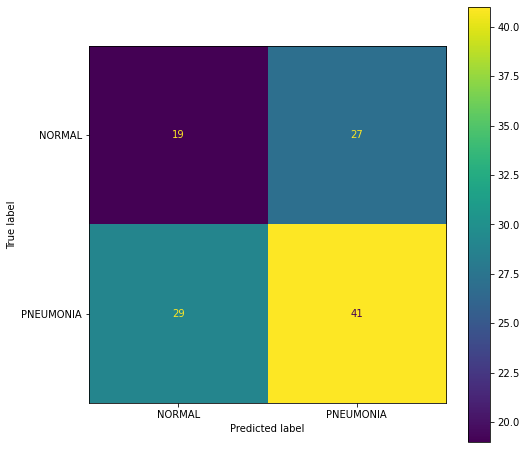

In [48]:
fx.create_confusion_matrix(model_CustomResNet50, val_generator)

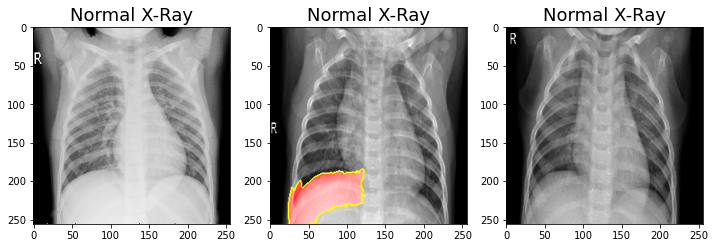

In [53]:
fx.display_lime(model_CustomResNet50, val_generator)